# 5.3 CNN transfer learning

## 5.3.1 Features extraction

In [6]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 3s 0us/step


In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 5.3.1 Quick features extraction without data augmentation

In [9]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r"..\data\Dogs vs Cats\NN Input"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [11]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels

In [12]:
train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
train_features = np.reshape(train_features, (2000, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [17]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [18]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Epoch 1/30
100/100 [==============================] - 5s 45ms/step - loss: 0.6044 - acc: 0.6620 - val_loss: 0.4493 - val_acc: 0.8480
Epoch 2/30
100/100 [==============================] - 4s 38ms/step - loss: 0.4319 - acc: 0.8090 - val_loss: 0.3673 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 4s 38ms/step - loss: 0.3655 - acc: 0.8485 - val_loss: 0.3266 - val_acc: 0.8750
Epoch 4/30
100/100 [==============================] - 4s 39ms/step - loss: 0.3185 - acc: 0.8590 - val_loss: 0.3026 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 4s 38ms/step - loss: 0.2914 - acc: 0.8810 - val_loss: 0.2861 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 4s 41ms/step - loss: 0.2646 - acc: 0.8995 - val_loss: 0.2746 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 0.2447 - acc: 0.9125 - val_loss: 0.2674 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 4s 37ms/step - 

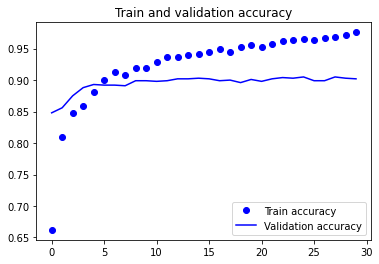

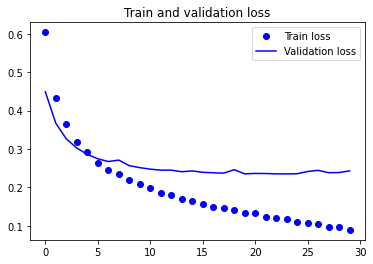

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Train and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Train and validation loss")
plt.legend()

plt.show()

## 5.3.1 Features extraction with data augmentation

In [20]:
from keras import models
from keras import layers

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Freeze VGG16 layers.

In [22]:
len(model2.trainable_weights)

30

In [23]:
conv_base.trainable = False

In [24]:
len(model2.trainable_weights)

4

In [29]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
train_generator = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
from tensorflow.keras import optimizers

model2.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(learning_rate=2e-5),
                      metrics=['acc'])

In [34]:
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=50)

c:\users\errry\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
100/100 [==============================] - 369s 4s/step - loss: 0.5329 - acc: 0.7550 - val_loss: 0.4073 - val_acc: 0.8520
Epoch 2/10
100/100 [==============================] - 370s 4s/step - loss: 0.4580 - acc: 0.8005 - val_loss: 0.3479 - val_acc: 0.8710
Epoch 3/10
100/100 [==============================] - 370s 4s/step - loss: 0.4235 - acc: 0.8145 - val_loss: 0.3270 - val_acc: 0.8740
Epoch 4/10
100/100 [==============================] - 370s 4s/step - loss: 0.3924 - acc: 0.8260 - val_loss: 0.2975 - val_acc: 0.8820
Epoch 5/10
100/100 [==============================] - 368s 4s/step - loss: 0.3866 - acc: 0.8275 - val_loss: 0.2865 - val_acc: 0.8850
Epoch 6/10
100/100 [==============================] - 384s 4s/step - loss: 0.3622 - acc: 0.8425 - val_loss: 0.2758 - val_acc: 0.8900
Epoch 7/10
100/100 [==============================] - 378s 4s/step - loss: 0.3592 - acc: 0.8385 - val_loss: 0.2691 - val_acc: 0.8910
Epoch 8/10
100/100 [==============================] - 356s 4s/step - 

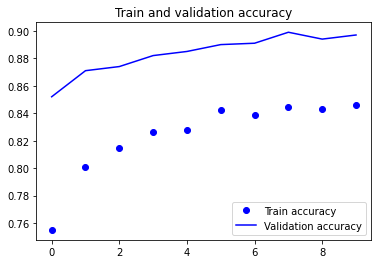

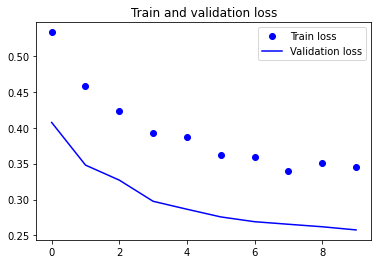

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Train and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Train and validation loss")
plt.legend()

plt.show()